In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import dateutil.parser
import time
from pandas import DataFrame
import datetime

import os

from scipy.special import gamma

import matplotlib.pyplot as plt
import Visualization

# Evaluación estadístico de salto
---

En este notebook evaluaremos el estadístico de salto definido en Huang & Tauchen [HT] (2005) como:

$$z_{TP, lm, t} = \frac{\log(RV_t) - \log(BV_t)}{\sqrt{(v_{bb}-v_{qq})\frac{1}{M}\max\left\{1, \frac{TP_t}{BV_t^2}\right\}}}$$

# Parámetros del estadístico
---

Siguiendo el paper de HT, asumimos que el log-precio de un activo evoluciona en el tiempo como:

$$dp(t) = \mu(t)dt + \sigma(t)dw(t) + dL_J(t)$$

por lo tanto, se define el retorno geométrico intradía como:

$$r_{t, j} = p_{t-1+\frac{j}{M}} - p_{t-1+\frac{j-1}{M}}$$

De esta manera, podemos evaluar los parámetros necesarios para evaluar el estadístico: la varianza realizada ($RV_t$), *bi-power variation* ($BV_t$) y *tri-power quarticity* ($TP_t$)

## Varianza realizada
---

La varianza realizada se define como:

$$RV_t = \sum_{j=1}^M r_{t, j}^2$$

## Bi-power variation
---

La variación *bi-power* se define como:

$$BV_t = \mu_1^{-2}\left(\frac{M}{M-1}\right)\sum_{j=2}^M|r_{t, j}||r_{t, j-1}|$$

$$BV_t = \frac{\pi}{2}\left(\frac{M}{M-1}\right)\sum_{j=2}^M|r_{t, j}||r_{t, j-1}|$$

## Tri-power quarticity
---

La cuarticidad *tri-power* se define como:

$$TP_t = M \ \mu_{4/3} \left(\frac{M}{M-2}\right)\sum_{j=3}^M|r_{t, j-2}|^{4/3}|\ r_{t, j-1}|^{4/3}\ |r_{t, j}|^{4/3}$$

donde $$\mu_k \equiv \frac{2^{k/2}}{\Gamma(1/2)}\Gamma\left[ \frac{(k+1)}{2} \right]$$

# Cálculo de los parámetros
---

Debido a que tendremos un valor del estadístico por cada día, antes de comenzar el cálculo de los parámetros debemos primero separar nuestros datos para cada día.

In [2]:
# Funcion que retorna una lista con entradas que corresponden a los datos de un dia para una accion

def sep_date(stockdata):
    
    # Hacemos un array con las fechas
    days = stockdata["dia"].drop_duplicates(keep="first").values
    
    # Creamos la lista donde guardaremos los dataframes diarios
    daily_dfs = []
    
    # Llenamos la lista
    for i in days:
        daily_dfs.append(stockdata.loc[stockdata["dia"] == i])
    
    # Retornamos la lista
    return daily_dfs

## Cálculo de los retornos
---
El primer paso es calcular los retornos según los supuestos del estadístico:

$$r_{t, j} = p_{t-1+\frac{j}{M}} - p_{t-1+\frac{j-1}{M}}$$

In [3]:
# Funcion que resamplea los precios segun el intervalo de tiempo que nos interese

def set_freq(stockdata, freq="15T"):
    
    # Definimos date_time como indice
    stockdata = stockdata.set_index("date_time")
    
    # Resampleamos los precios segun la frecuencia
    price_resamp = stockdata.precio.resample(freq).mean()
    price_resamp = price_resamp.between_time("9:30", "15:45")
    price_resamp = pd.DataFrame(price_resamp)
    
    return price_resamp

In [4]:
# Funcion que retorna un array de los retornos a una frecuencia dada

def get_returns(stockdailydata, lag=1):
    
    # Resampleamos los precios segun la frecuencia escogida
    price_15min = set_freq(stockdailydata)
    
    # Sacamos el logaritmo de los precios
    log_p = np.log(price_15min["precio"].copy())
    
    # Retornamos la razon de los log-precios
    return log_p.diff(periods=lag).values

## Cálculo: varianza realizada

La varianza realizada será: $$RV_t = \sum_{j=1}^M r_{t, j}^2$$
donde $$r_{t+j\delta, \delta} = p_{t+j\delta}-p_{t+(j-1)\delta}$$

In [5]:
# Realized volatility

def RV(stockdailydata, lag=1):
    
    # Obtenemos los retornos de los datos diarios
    ret = get_returns(stockdailydata)
    
    # Retornamos la suma de los retornos cuadrados
    return np.nansum(np.square(ret))

## Cálculo: bi-power variation

La variación *bi-power* será:

$$BV_t = \frac{\pi}{2}\left(\frac{M}{M-1}\right)\sum_{j=2}^M|r_{t, j}||r_{t, j-1}|$$

In [6]:
# Bi-power variation

def BV(stockdailydata):
    
    # Calculamos los retornos
    ret  = get_returns(stockdailydata)
    
    # Definimos las constantes
    M    = len(ret) #len(stockdailydata)
    coef = (np.pi/2.)*float(M/(M-1.))
    
    # Inicializamos la lista que guarda los terminos de la sumatoria
    sums = []
    
    # Calculamos los terminos
    for i in range(2, M):
        sums.append(np.abs(ret[i] * ret[i-1]))
        
    # Retornamos la suma de los terminos que hay en la lista
    return coef*np.nansum(np.array(sums))

## Cálculo: tri-power quarticity

Finalmente, el tri-power quarticity es:

$$TP_t = M \ \mu_{4/3} \left(\frac{M}{M-2}\right)\sum_{j=3}^M|r_{t, j-2}|^{4/3}|\ r_{t, j-1}|^{4/3}\ |r_{t, j}|^{4/3}$$

donde $$\mu_k \equiv \frac{2^{k/2}}{\Gamma(1/2)}\Gamma\left[ \frac{(k+1)}{2} \right]$$

In [7]:
# Tri-power quarticity

def TP(stockdailydata):
    
    # Calculamos los retornos absolutos
    stockdailyret = np.abs(get_returns(stockdailydata))
    
    # Definimos las constantes
    M    = len(stockdailyret) #len(stockdailydata)
    mu43 = np.float_power(2., 2./3.)*gamma(7./6.)/gamma(0.5)
    coef = mu43*M*(M/(M-2))
    p    = 4./3.
    
    # Inicializamos la lista donde guardaremos los terminos de la sumatoria
    sums = []
    
    # Calculamos los terminos de la sumatoria
    for i in range(3, M):
        temp1 = stockdailyret[i]*stockdailyret[i-1]*stockdailyret[i-2]
        temp2 = np.float_power(temp1, p)
        
        # Guardamos los terminos de la sumatoria en la lista sums
        sums.append(temp2)
    
    # Retornamos la suma-producto
    return coef*np.nansum(np.array(sums))

## Cálculo del estadístico de salto
---
Ya habiendo calculado los parámetros del estadístico podemos calcular su valor:

$$z_{TP, lm, t} = \frac{\log(RV_t) - \log(BV_t)}{\sqrt{(v_{bb}-v_{qq})\frac{1}{M}\max\left\{1, \frac{TP_t}{BV_t^2}\right\}}}$$

con $$v_{qq}=2$$ $$v_{bb}=\left(\frac{\pi}{2}\right)^2+\pi-3$$

In [8]:
# Jump statistic

def JS(stockdata):
    
    # Guardamos las fechas para indexar los datos al final
    days = stockdata["dia"].drop_duplicates(keep="first").values
    
    # Inicializamos la lista donde se guardan los resultados
    js_result = []
    
    # Definimos las constantes
    vbb = (np.pi/2)**2 + np.pi - 3.
    vqq = 2.
    
    # Separamos nuestros datos por dias
    stockdailydata = sep_date(stockdata)
    
    # Hacemos el calculo de los valores diarios
    for df in stockdailydata:
        
        # Definimos las constantes DIARIAS
        M = len(df)
        #M = len(get_returns(df))
        
        # Calculamos los parametros
        rv = RV(df)
        bv = BV(df)
        tp = TP(df)
        
        # Calculamos el numerador de la operacion
        num = np.log(rv) - np.log(bv)
        
        # Calculamos el denominador de la operacion
        temp = tp/(bv*bv)
        den  = np.sqrt( (vbb-vqq) * 1./M * max(1., temp) )
        
        # Guardamos el resultado en proporcion de superacion del valor critico 1.96
        js_result.append((num/den)/1.96)
        
    # Verificamos si se supera el valor critico
    crit_val = (np.array(js_result) >= 1.).astype(int)
        
    # Retornamos el resultado
    return DataFrame({"JS_statistic": js_result, "OverCritValue": crit_val}, index=days)

# Aplicación - ECOPETL
---

Ahora podemos aplicar el procedimiento desarrollado a los datos de la acción de ECOPETL. Primero, importamos los datos. Luego, aplicamos las funciones previamente presentadas. Finalmente, se presentan las gráficas de todos los parámetros aquí calculados.

In [9]:
# Definimos la direccion del directorio
pathTesis = os.getcwd()
filepath  = pathTesis + "/depth_data.csv"

In [10]:
# Importamos los datos
data = %time pd.read_csv(filepath, parse_dates=["date_time"])

CPU times: user 563 ms, sys: 32.2 ms, total: 595 ms
Wall time: 595 ms


In [11]:
# Calculamos el estadistico
js_test = %time JS(data)

CPU times: user 2.08 s, sys: 4.49 ms, total: 2.08 s
Wall time: 2.08 s


In [12]:
# Verificamos si hay algun NaN en los resultados
js_test.isnull().values.sum()

0

In [13]:
js_test.head(10)

,JS_statistic,OverCritValue
2017-03-03,1.992114,1
2017-03-06,-2.589750,0
2017-03-07,-3.246811,0
2017-03-08,-3.719601,0
2017-03-09,-1.916236,0
2017-03-10,-2.588612,0
2017-03-13,6.487625,1
2017-03-14,14.283909,1
2017-03-15,-0.061760,0
2017-03-16,-1.763261,0


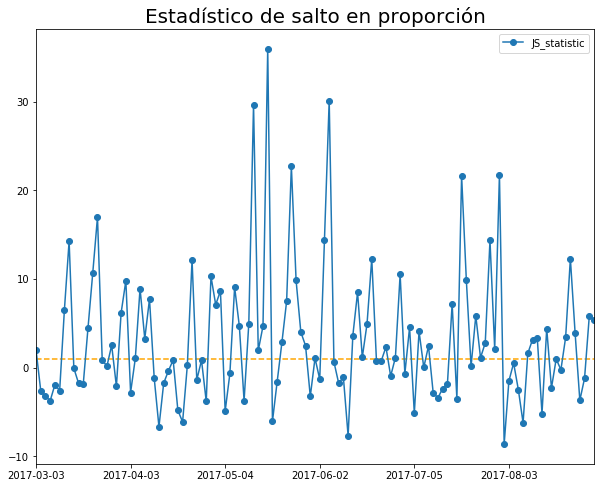

In [14]:
pd.DataFrame(js_test["JS_statistic"]).plot(figsize=(10, 8), marker="o")
plt.title("Estadístico de salto en proporción", fontsize=20)
plt.hlines(y=1, xmin=0, xmax=len(js_test), linestyles="--", color="orange")
plt.show()

In [15]:
# ¿Que proporcion de dias muestran saltos?
prop = 100.*(js_test.OverCritValue.sum())/len(js_test.OverCritValue)
print("El %.4f%% de los días analizados presentan saltos" % prop)

El 52.1008% de los días analizados presentan saltos


# Gráficas
---
Ahora presentamos una visualización del estadístico de *realized Volatility*, *bi-power Variation* y *tri-power quarticity*

In [16]:
# Guardamos los dias
dias = data["dia"].drop_duplicates(keep="first").values

# Separamos los datos por dia
datos_diarios = sep_date(data)

# Inicializamos listas donde se guardan los resultados
realized_volat = []
bipower_var    = []
tripower_quart = []

# Calculamos RV, BV, TP diarios
for df in datos_diarios:
    realized_volat.append(RV(df))
    bipower_var.append(BV(df))
    tripower_quart.append(TP(df))

# Convertimos resultados en DataFrames
realized_volat = DataFrame({"RealizedVariance": realized_volat}, index=dias)
bipower_var    = DataFrame({"BipowerVariation": bipower_var}, index=dias)
tripower_quart = DataFrame({"TripowerQuarticity": tripower_quart}, index=dias)

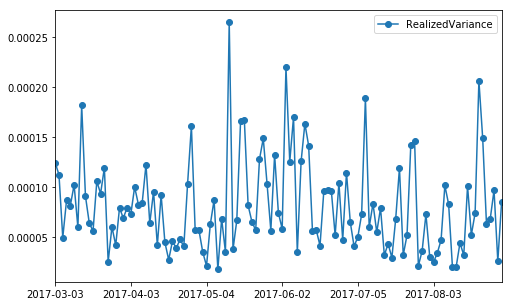

In [17]:
# Grafica RV

realized_volat.plot(figsize=(8, 5), marker="o")
plt.show()

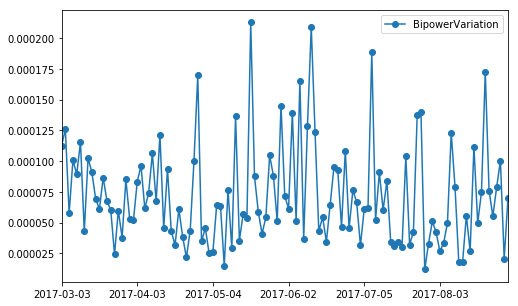

In [18]:
# Grafica BV

bipower_var.plot(figsize=(8, 5), marker="o")
plt.show()

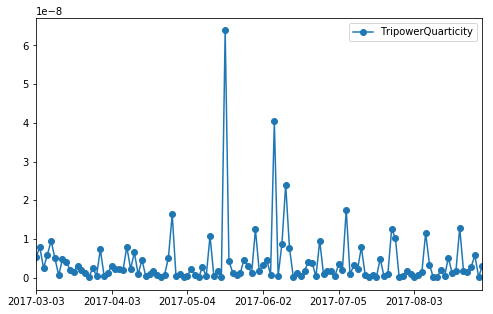

In [19]:
# Grafica TP

tripower_quart.plot(figsize=(8, 5), marker="o")
plt.show()

In [20]:
realized_volat.min() # Vemos que el minimo es mayor a cero

RealizedVariance    0.000018
dtype: float64

In [21]:
bipower_var.min() # Vemos que el minimo es mayor a cero

BipowerVariation    0.000012
dtype: float64

In [22]:
tripower_quart.min() # Vemos que el minimo es mayor a cero

TripowerQuarticity    6.047775e-11
dtype: float64

In [23]:
js_test.min()

JS_statistic    -8.616659
OverCritValue    0.000000
dtype: float64